In [1]:
import pandas as pd
import numpy as np

import json
import wandb
import matplotlib.pyplot as plt
from datetime import datetime


from utils.ml_utils import metrics, ml, calculate_weight, normalize_data
from utils.utils import make_table
from utils.wandb_logging import init_exp, log_params, finish_exp

import warnings
warnings.filterwarnings("ignore")

from typing import List, Dict

In [2]:
cols = ["account_id", "name", "point", "call_count", "total_call_time", "total_exclusive_time", "min_call_time", "max_call_time", "sum_of_squares", "instances", "language", "app_name", "app_id", "scope", "host", "display_host", "pid", "agent_version", "labels"]
data_raw = pd.read_csv("Data/metrics_collector.tsv", names = cols, sep="\t")

In [3]:
data = make_table(data_raw)

In [67]:
from pyod.models.ecod import ECOD
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest

In [105]:
def ml(data: pd.DataFrame, start_date: datetime, end_date: datetime) -> Dict[str, pd.DataFrame]:

    """
    Вход 
    - список колонок по которым нужно обучить модель list(str) 
    - дата начала промежутка datetime
    - дата конца промежутка datetime
    - датафрейм с поминутными метриками

    Выход
    dict: 
        - датафрейм с колонками 
            1. Таймстемп datetime
            2. Булево значение по аномалии label
            3. Вероятность по аномалии probability 
            4. Изначальное значение value
    """

    def fit_clf(model, data: np.ndarray) -> pd.DataFrame:
        model.fit(data)
        labels = model.labels_
        scores = model.decision_scores_
        threshold = model.threshold_
        threshold = (threshold - np.min(scores)) / (np.max(scores) - np.min(scores))

        return pd.DataFrame({
            "labels": labels,
            "probability": normalize_data(scores)
        }), threshold
    
    column_names = ["web_response", "throughput", "apdex", "error"]
    weights = calculate_weight(data, column_names, start_date, end_date)
    column_names.extend(['time', 'time_numeric'])
    filtered_df = data[(data['time'] >= start_date) & (data['time'] <= end_date)][column_names]

    result = {}

    for column in column_names:
        data_values = filtered_df[['time_numeric', column]].values

        if column == "apdex":
            clf = ECOD(contamination=0.004, n_jobs=-1)
        elif column == "web_response":
            clf = IForest(contamination=0.001)
        elif column == "throughput":
            clf = HBOS(contamination=0.0035)
        elif column == "error":
            clf = IForest(contamination=0.0011)
        else:
            continue

        clf_df, threshold = fit_clf(clf, data_values)
        clf_df["time"] = filtered_df["time"].values
        clf_df["value"] = filtered_df[column].values
        result[column] = clf_df

        # scaled_weight = 2/(1 + np.exp(-weights[column]))
        # # scaled_weight = (weights[column] / (weights[column] + 1)) * 2
        # print(column, weights[column], scaled_weight)
        # result[column].probability = result[column].probability * scaled_weight
        # result[column].labels = (result[column].probability > threshold).astype(int)

    return result

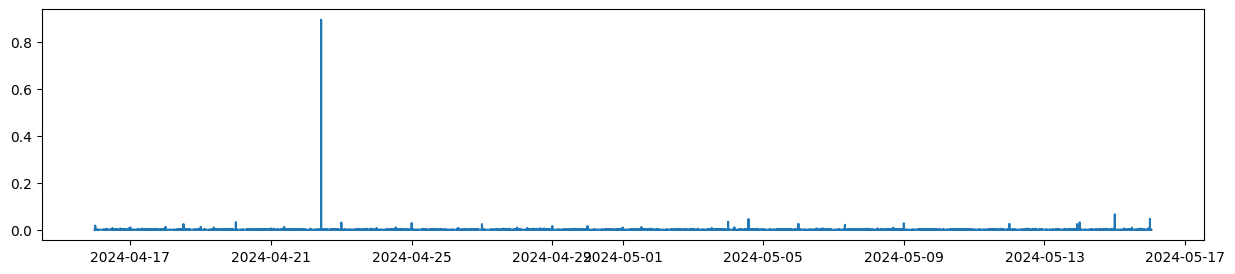

In [106]:
plt.figure(figsize=(15, 3)) 
plt.plot(data.time, data.error)
plt.show()

In [4]:
start_str = "2024-05-12 11:32:00"
end_str = "2024-05-14 11:58:00"
date_format = "%Y-%m-%d %H:%M:%S"

start_obj = datetime.strptime(start_str, date_format)
end_obj = datetime.strptime(end_str, date_format)

res = ml(data, start_obj, end_obj)

In [108]:
res.keys()

dict_keys(['web_response', 'throughput', 'apdex', 'error'])

In [5]:
df = res["apdex"]

In [8]:
df

'{"labels":{"0":0,"1":0,"2":0,"3":0,"4":0,"5":0,"6":0,"7":0,"8":0,"9":0,"10":0,"11":0,"12":0,"13":0,"14":0,"15":0,"16":0,"17":0,"18":0,"19":0,"20":0,"21":0,"22":0,"23":0,"24":0,"25":0,"26":0,"27":0,"28":0,"29":0,"30":0,"31":0,"32":0,"33":0,"34":0,"35":0,"36":0,"37":0,"38":0,"39":0,"40":0,"41":0,"42":0,"43":0,"44":0,"45":0,"46":0,"47":0,"48":0,"49":1,"50":0,"51":0,"52":0,"53":0,"54":0,"55":0,"56":0,"57":0,"58":0,"59":0,"60":0,"61":0,"62":0,"63":0,"64":0,"65":0,"66":0,"67":0,"68":0,"69":0,"70":0,"71":0,"72":0,"73":0,"74":0,"75":0,"76":0,"77":0,"78":0,"79":0,"80":0,"81":0,"82":0,"83":0,"84":0,"85":0,"86":0,"87":0,"88":0,"89":0,"90":0,"91":0,"92":0,"93":0,"94":0,"95":0,"96":0,"97":0,"98":0,"99":0,"100":0,"101":0,"102":0,"103":0,"104":0,"105":0,"106":0,"107":0,"108":0,"109":0,"110":0,"111":0,"112":0,"113":0,"114":0,"115":0,"116":0,"117":0,"118":0,"119":0,"120":0,"121":0,"122":0,"123":0,"124":0,"125":0,"126":0,"127":0,"128":0,"129":0,"130":0,"131":0,"132":0,"133":0,"134":0,"135":0,"136":0,"1

In [9]:
data = json.loads(df)
df = pd.DataFrame(data)

,labels,probability,time,value
0,0,0.521514,1715513520000,0.999373
1,0,0.503692,1715513580000,0.999206
2,0,0.492273,1715513640000,0.996576
3,0,0.642069,1715513700000,0.995632
4,0,0.537631,1715513760000,0.996372
...,...,...,...,...
2902,0,0.359592,1715687640000,0.998397
2903,0,0.362914,1715687700000,0.999603
2904,0,0.421702,1715687760000,0.999766
2905,0,0.399104,1715687820000,0.999702


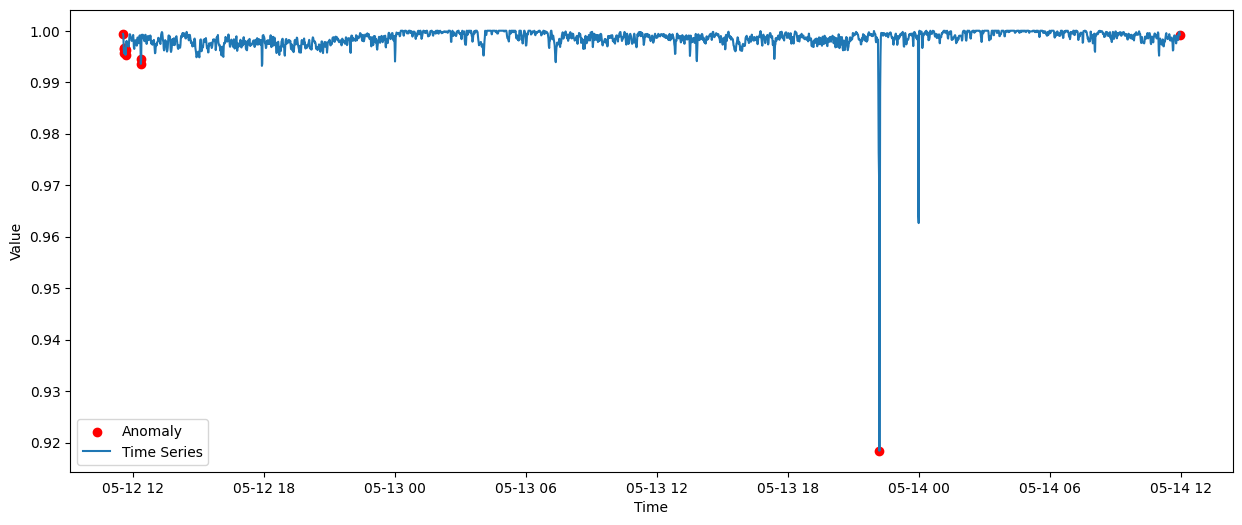

In [121]:
import matplotlib.pyplot as plt

# Создаем график
plt.figure(figsize=(15, 6))

# Отмечаем аномалии красными точками
plt.scatter(df['time'][df['labels'] == 1], df['value'][df['labels'] == 1], color='red', label='Anomaly')

# Строим временной ряд
plt.plot(df['time'], df['value'], label='Time Series')

# Добавляем легенду
plt.legend()

# Добавляем названия осей
plt.xlabel('Time')
plt.ylabel('Value')

# Отображаем график
plt.show()

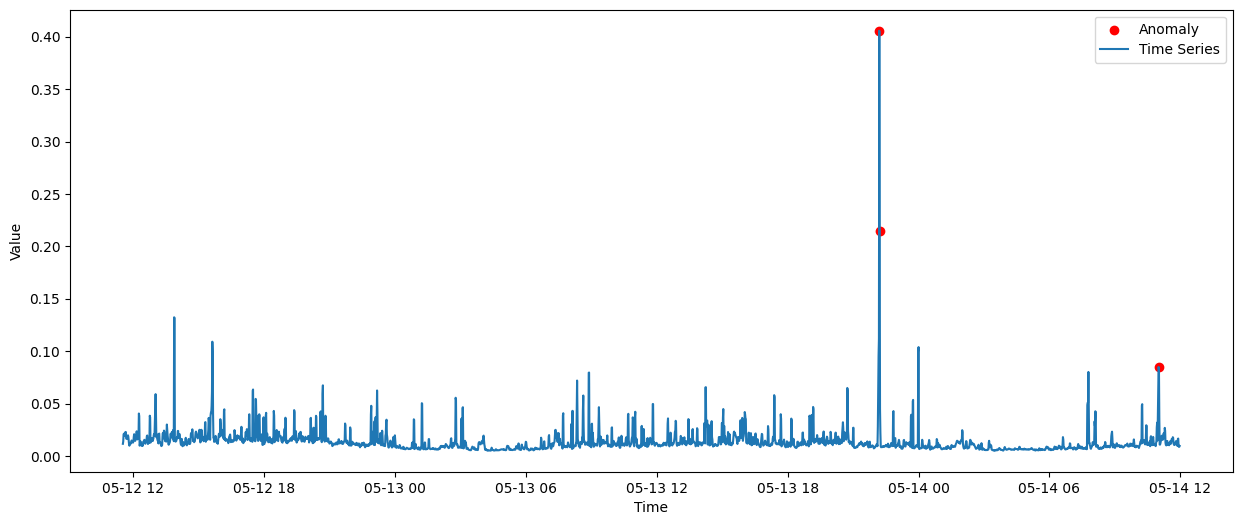

In [111]:
import matplotlib.pyplot as plt

# Создаем график
plt.figure(figsize=(15, 6))

# Отмечаем аномалии красными точками
plt.scatter(df['time'][df['labels'] == 1], df['value'][df['labels'] == 1], color='red', label='Anomaly')

# Строим временной ряд
plt.plot(df['time'], df['value'], label='Time Series')

# Добавляем легенду
plt.legend()

# Добавляем названия осей
plt.xlabel('Time')
plt.ylabel('Value')

# Отображаем график
plt.show()

In [156]:
%%time
weights = calculate_weight(res, start_obj, end_obj)

Column: web_response, Overall Variance: 0.000388398328818089, Overall Mean: 0.014054376522158416, Without Anomaly Sum: 0.00015611627895546247
Column: throughput, Overall Variance: 1464579.4283636156, Overall Mean: 3624.7797536517833, Without Anomaly Sum: 2642037.262015677
Column: apdex, Overall Variance: 3.1235220184250507e-05, Overall Mean: 0.9985337442498524, Without Anomaly Sum: 1.9693548863271425e-06
Column: error, Overall Variance: 2.9563878510515153e-05, Overall Mean: 0.00033519405510003844, Without Anomaly Sum: 7.045508077208396e-07
CPU times: user 4.12 ms, sys: 1.27 ms, total: 5.39 ms
Wall time: 5.09 ms


In [157]:
weights

{'web_response': 0.40194889465804423,
 'throughput': 1.803956283182021,
 'apdex': 0.06304917572888233,
 'error': 0.023831474191393663}

In [158]:
res.keys()

dict_keys(['web_response', 'throughput', 'apdex', 'error'])

In [160]:
df[df.labels == 1].probability.sort_values()

240     0.996253
241     0.996253
247     0.996253
272     0.996253
273     0.996253
279     0.996253
282     0.996253
283     0.996253
628     1.000000
2068    1.000000
Name: probability, dtype: float64

In [161]:
df[df.labels == 0].probability.sort_values()

1959    0.000000
434     0.000000
433     0.000000
432     0.000000
431     0.000000
          ...   
267     0.978986
266     0.978986
265     0.978986
263     0.978986
257     0.978986
Name: probability, Length: 2897, dtype: float64

In [162]:
df.probability.sort_values()

482     0.000000
1828    0.000000
1829    0.000000
1830    0.000000
1831    0.000000
          ...   
282     0.996253
283     0.996253
241     0.996253
2068    1.000000
628     1.000000
Name: probability, Length: 2907, dtype: float64

In [179]:
df.probability = df.probability*1.28

In [164]:
df.columns

Index(['labels', 'probability', 'time', 'value'], dtype='object')

In [165]:
df.labels.value_counts()

labels
0    2897
1      10
Name: count, dtype: int64

In [166]:
df

,labels,probability,time,value
0,0,2.543067e-11,2024-04-26 11:32:00,4584.0
1,0,2.543067e-11,2024-04-26 11:33:00,4631.0
2,0,2.543067e-11,2024-04-26 11:34:00,4805.5
3,0,2.543067e-11,2024-04-26 11:35:00,4666.0
4,0,2.543067e-11,2024-04-26 11:36:00,4685.0
...,...,...,...,...
2902,0,3.727492e-01,2024-04-28 11:54:00,4199.5
2903,0,3.727492e-01,2024-04-28 11:55:00,4227.0
2904,0,3.727492e-01,2024-04-28 11:56:00,4023.0
2905,0,3.727492e-01,2024-04-28 11:57:00,3914.0


In [172]:
(1/(1 + np.exp(-1.8)))*2

1.7162978701990246

In [176]:
(1.8 / (1.8 + 1)) * 2

1.2857142857142858

In [43]:
config_model_name = "LOF"
metrics_dict = {}
timeseries_cols = ["web_response", "throughput", "apdex", "error"]

with open('config.json', 'r') as file:
    config = json.load(file)


for timeseries_col in timeseries_cols:
    model = LOF(**config[config_model_name][timeseries_col])

    # fit predict model 
    X = data_raw[["time", timeseries_col]]
    model.fit(X)
    predictions = model.predict(X)
    print(predictions)
    metrics_dict[timeseries_col] = metrics(X, predictions, timeseries_col)


    with open('secrets/wandb_secret.txt', 'r') as file:
        api_key = file.read()

    wandb.login(key=api_key)

    wandb.init(project="redlab-hack", tags=[config_model_name, timeseries_col])
    wandb.log(config[config_model_name][timeseries_col])
    wandb.log(metrics_dict)
    wandb.finish()

[1 1 1 ... 1 1 1]


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [ ]:
def train_model(data: pd.DataFrame, model, params: dict, start: pd.datetime, end: pd.datetime, recalculate = 0) -> dict:

    # fit predict model 
    model.fit(data)
    predictions = model.predict() 

    metrics = metrics(predictions)

    # wandb logging 
    log_params(metrics)
    

In [ ]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [ ]:
type(LOF(n_neighbors=5))

pyod.models.lof.LOF

In [ ]:
# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth)

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
